In [103]:
import Pkg

Pkg.add("SparseArrays")
Pkg.add("LinearAlgebra")
Pkg.add("SpecialFunctions")
Pkg.add("Arpack")   
Pkg.add("DelimitedFiles")
Pkg.add("NPZ")
Pkg.add("Random")
Pkg.add("Statistics")
Pkg.add("ExpmV")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.to

In [1]:
using SparseArrays
using LinearAlgebra
using SpecialFunctions  # for besselj
using Arpack  # for eigs on sparse matrices
using Statistics
using Random
using DelimitedFiles
using NPZ
using ExpmV


In [15]:
function von_neumann_entropy(ψ::Vector{<:Complex}, cut::Int, L::Int)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        p = abs2(s)
        if p > 0 && p > 1e-15
            S -= p * log(p)
        end
    end
    return S
end

von_neumann_entropy (generic function with 1 method)

In [2]:
using LinearAlgebra
using Random

function random_product_state(L::Int)
    product_state = nothing

    for i in 1:L
        θ1 = rand() * π
        θ2 = rand() * π
        ϕ1 = rand() * 2π
        ϕ2 = rand() * 2π

        c1 = cos(θ1 / 2)
        c2 = exp(im * ϕ1) * sin(θ1 / 2) * sin(θ2 / 2)
        c3 = exp(im * ϕ2) * sin(θ1 / 2) * cos(θ2 / 2)

        temp_state = [c1, c2, c3]

        if i == 1
            product_state = temp_state
        else
            product_state = kron(product_state, temp_state)
        end
    end

    # Normalize the state
    product_state /= norm(product_state)

    return product_state
end

random_product_state (generic function with 1 method)

In [3]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    H = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        H += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    return H, sz2l, szl 
end

Hamiltonian (generic function with 1 method)

In [9]:
using ExpmV

function time_evolution(ψ::Vector{ComplexF64}, dt::Float64, L)
    ψ /= norm(ψ)
    H, _, _ = Hamiltonian(L)

    # Apply exp(-im * H * dt) directly to ψ
    ψ_new = expmv(-im * dt, H, ψ)

    # Normalize the state
    ψ_new /= norm(ψ_new)
    
    return ψ_new
end


time_evolution (generic function with 2 methods)

In [13]:
state = time_evolution(random_product_state(13), 1.0, 13)

1594323-element Vector{ComplexF64}:
 0.00010211281636507455 + 0.0im
 0.00014462754422347353 - 9.828925909981198e-5im
   2.517974403378482e-5 + 0.00013901381711005156im
  -6.108665609653795e-6 - 2.2684426829458057e-5im
  -3.048703309335731e-5 - 2.6249170505858126e-5im
  1.9319637667610964e-5 + 1.882361850158519e-5im
  0.0001442860175218071 + 8.194309501865544e-5im
   7.537084379209119e-5 + 0.00013600630603939262im
   2.211323841559173e-5 + 1.8445781046150038e-5im
   3.963480338393452e-5 - 0.00023094932675959626im
                        ⋮
  1.3962767982762509e-5 + 4.661021821705555e-5im
 -1.0883567121762958e-6 - 2.667217316047589e-6im
  6.8036975363093366e-6 - 1.5725861554589464e-5im
   -1.44010842907291e-6 + 2.5289639872052303e-6im
  -2.098830909549493e-7 - 1.8383752999378518e-7im
  -3.849986979109804e-7 + 4.7345028693136696e-8im
  -6.614358293957353e-6 - 7.433878439857039e-7im
  -9.742358117427006e-7 + 1.0258558821418575e-6im
  1.6131308557871078e-7 + 1.960248442356031e-6im

In [16]:
von_neumann_entropy(state, 6, 13)

1.0376024678276465

In [ ]:
function Entropy_t(L::Int, T::Float64, dt::Float64, p::Float64, direction::String, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    H, sz2l, szl = Hamiltonian(L)
    
    if direction == "Z2"
        sm_list = sz2l
    elseif direction == "Z"
        sm_list = szl
    else
        error("Invalid direction: $direction. Choose \"Z2\" or \"Z\".")
    end


    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        #push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m = real(s_t' * (m_op * s_t))
                    if rand() < p_m
                        s_t = (m_op * s_t) / sqrt(p_m)
                    else
                        s_t = (s_t - m_op * s_t) / sqrt(1 - p_m)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dir$(direction),s$(shot).npy"
    #npzwrite(filename, S_list)

    return S_list
end

Entropy_t (generic function with 2 methods)

In [43]:
Entropy_t(8, 100.0, 1.0, 1.0, "Z2", 1)

100-element Vector{Float64}:
 -2.442490654175349e-15
 -0.29488101937856404
 -0.10971139284998044
 -0.3327657850498025
 -0.32936503573744114
 -0.4399987537940653
 -0.4755376084713212
 -0.09492770492534985
 -0.6946102017788871
 -0.5267667200171089
  ⋮
 -0.3564001018127094
 -0.3027660910373713
 -0.8717254264415673
 -0.14151212240084665
 -0.17606351366724482
 -0.9818519095106251
 -0.41326309050713816
 -0.3106212877805765
 -0.32754592760356194

In [42]:
function I3(psi::Vector{ComplexF64})
    log3(x) = log(x) / log(3)

    L = Int(round(log3(length(psi))))
    qL = L ÷ 4

    SA   = von_neumann_entropy(psi, qL, L)
    SB   = von_neumann_entropy(psi, 2qL, L)
    SC   = von_neumann_entropy(psi, 3qL, L)
    SABC = von_neumann_entropy(psi, L, L)
    SAB  = von_neumann_entropy(psi, 2qL, L)
    SAC  = von_neumann_entropy(psi, 3qL, L)
    SBC  = von_neumann_entropy(psi, 3qL, L)
    


    return SA + SB + SC + SABC - SAB - SAC - SBC
end

I3 (generic function with 1 method)

In [ ]:
function Entropy_t_z(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    H, sz2l, szl = Hamiltonian(L)
    sm_list = szl
    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        #push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m_mone = 0.5 * real(s_t' * (sz2l[l]-sm_list[l]) * s_t)
                    p_m_one = 0.5 * real(s_t' * (sz2l[l] + sm_list[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_mone
                        s_t = 0.5 * ((sz2l[l]-sm_list[l]) * s_t) / sqrt(p_m_mone)
                    elseif p_m_mone < x1 < p_m_one + p_m_mone
                        s_t = 0.5 * ((sz2l[l]+sm_list[l]) * s_t) / sqrt(p_m_one)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_mone - p_m_one)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ,s$(shot).npy"
    npzwrite(filename, S_list)

    return S_list
end

Entropy_t_z (generic function with 2 methods)

In [8]:
include("s3.jl")

Hamiltonian (generic function with 1 method)

In [10]:
Entropy_t_z(8, 100.0, 1.0, 0.3, 398)

100-element Vector{Float64}:
  2.8865798640254035e-15
  0.3632675500196728
  0.6417750673048793
  0.24375281922998004
 -0.09757885187994902
  0.019680427386606414
  0.11696451437975335
  0.6725680799791564
  0.4235830469305314
 -0.044589198460111
  ⋮
  0.44364228970813957
  0.24521141249263445
 -0.07120718117375735
  0.19959054060977222
  1.925929944387236e-34
 -0.018967096499422187
  0.4643897152328975
 -0.039535302335464505
 -0.2774209069115454

for L in [8]
    for T in [100.0]
        for dt in [1.0]
            for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                for shot in 1:500
                    Entropy_t_z(L, T, dt, p, shot)
                end
            end
        end
    end
end

This took 320 minutes to run

### Ancilla purification code

In [7]:
using SparseArrays
using LinearAlgebra
using Arpack
using Statistics
using Random
using DelimitedFiles
using NPZ
using ExpmV

function von_neumann_entropy(ψ::Vector{<:Complex}, cut::Int, L::Int)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        if s > 1e-15
            p = abs2(s)
            S -= p * log(p)
        end
    end
    return S
end

function random_product_state(L::Int)
    product_state = nothing

    for i in 1:L
        θ1 = rand() * π
        θ2 = rand() * π
        ϕ1 = rand() * 2π
        ϕ2 = rand() * 2π

        c1 = cos(θ1 / 2)
        c2 = exp(im * ϕ1) * sin(θ1 / 2) * sin(θ2 / 2)
        c3 = exp(im * ϕ2) * sin(θ1 / 2) * cos(θ2 / 2)

        temp_state = [c1, c2, c3]

        if i == 1
            product_state = temp_state
        else
            product_state = kron(product_state, temp_state)
        end
    end

    # Normalize the state
    product_state /= norm(product_state)

    return product_state
end

function time_evolution(ψ::Vector{ComplexF64}, dt::Float64, L)
    ψ /= norm(ψ)
    Ha, Hb, Hc, _, _ = Hamiltonian(L)
    a = 2π * rand()
    b = 2π * rand()
    c = 2π * rand()
    # Apply exp(-im * H * dt) directly to ψ
    H = a * Ha + b * Hb + c * Hc
    ψ_new = expmv(-im * dt, H, ψ)

    # Normalize the state
    ψ_new /= norm(ψ_new)
    
    return ψ_new
end

function I3(psi::Vector{ComplexF64})
    log3(x) = log(x) / log(3)

    L = Int(round(log3(length(psi))))
    qL = L ÷ 4

    SA   = von_neumann_entropy(psi, qL, L)
    SB   = von_neumann_entropy(psi, 2qL, L)
    SC   = von_neumann_entropy(psi, 3qL, L)
    SABC = von_neumann_entropy(psi, L, L)
    SAB  = von_neumann_entropy(psi, 2qL, L)
    SAC  = von_neumann_entropy(psi, 3qL, L)
    SBC  = von_neumann_entropy(psi, 3qL, L)
    
    return SA + SB + SC + SABC - SAB - SAC - SBC
end

### This function is for Z measurements only

function Entropy_t_z(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    _, _, _, sz2l, szl = Hamiltonian(L)
    sm_list = szl
    steps = Int(floor(T / dt))

    for _ in 1:steps
        #push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt, L)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m_mone = 0.5 * real(s_t' * (sz2l[l]-sm_list[l]) * s_t)
                    p_m_one = 0.5 * real(s_t' * (sz2l[l] + sm_list[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_mone
                        s_t = 0.5 * ((sz2l[l]-sm_list[l]) * s_t) / sqrt(p_m_mone)
                    elseif p_m_mone < x1 < p_m_one + p_m_mone
                        s_t = 0.5 * ((sz2l[l]+sm_list[l]) * s_t) / sqrt(p_m_one)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_mone - p_m_one)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ,s$(shot).npy"
    npzwrite(filename, S_list)

    return S_list
end

function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha, Hb, Hc, sz2l, szl 
end

Hamiltonian (generic function with 1 method)

In [1]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha, Hb, Hc, sz2l, szl 
end

Hamiltonian (generic function with 1 method)

In [13]:
function entropy_vn(ψ::Vector{<:Complex}, L::Int, subsystem::AbstractArray{Int})
    cut = length(subsystem)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        if s > 1e-15
            p = abs2(s)
            S -= p * log(p)
        end
    end
    return S
end

entropy_vn (generic function with 1 method)

Code run

In [4]:
include("s3.jl")

time_evolution (generic function with 1 method)

In [6]:
@time Entropy_t_z(8, 100.0, 1.0, 0.4, 3980)

  8.099042 seconds (866.58 k allocations: 18.854 GiB, 35.03% gc time)


100-element Vector{Float64}:
  2.886579864025403e-15
 -0.8015475621045871
 -1.89590149229082
 -2.4124165469827057
 -2.5739457584677155
 -2.694335010511299
 -2.7781091544423626
 -2.7867754230430943
 -2.815526335454182
 -2.843352182646453
  ⋮
 -2.8928928766145434
 -2.9446526907123074
 -2.9136591748474663
 -2.8947762851787795
 -2.9112843160398754
 -2.9413920429708353
 -2.9095577516682924
 -2.9025903345373596
 -2.9169584064808793

### ITensors benchmarking

In [30]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha
end

Hamiltonian (generic function with 1 method)

In [31]:
Ha = Hamiltonian(8)

6561×6561 SparseMatrixCSC{ComplexF64, Int64} with 11664 stored entries:
⎡⠻⣦⡀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⢬⠻⣦⡀⠀⠀⠀⠀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⢻⣶⡀⢀⠀⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⢈⡿⣯⣁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢤⡀⠀⠁⠘⠻⢆⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠉⠀⠀⠀⠀⠉⣱⣾⡁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠈⠿⣧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠀⠀⠀⠀⠙⠦⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣦⡗⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠉⠻⣦⡀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡰⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠎⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠈⠻⣦⣀⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢼⠻⣦⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠲⣄⠀⠀⠀⠀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢻⣶⡀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⡿⢏⣀⠀⠀⠀⠀⣀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠱⣦⡄⢀⠀⠈⠓⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢉⣻⣾⡁⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⠀⠁⠈⠿⣧⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠈⠻⣦⡓⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠈⠻⣦⎦

In [32]:
## Check if Ha is Hermitian
ishermitian(Ha)

true

In [33]:
using LinearAlgebra
using SparseArrays
using Arpack: eigs

In [36]:
vals, vecs = eigs(Ha; nev=1, which=:SR)
lowest_eig = vals[1]

println("Lowest eigenvalue: ", lowest_eig)

Lowest eigenvalue: -10.452503719011009 - 1.4459599210576632e-16im


In [39]:
@show op("S+", s)

op("S+", s) = ITensor ord=2
Dim 1: (dim=3|id=114|"S=1,Site,n=1")' <Out>
 1: QN("Sz",2) => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
Dim 2: (dim=3|id=114|"S=1,Site,n=1") <In>
 1: QN("Sz",2) => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
NDTensors.BlockSparse{Float64, Vector{Float64}, 2}
 3×3
Block(1, 2)
 [1:1, 2:2]
 1.4142135623730951

Block(2, 3)
 [2:2, 3:3]
 1.4142135623730951


ITensor ord=2
(dim=3|id=114|"S=1,Site,n=1")' <Out>
 1: QN("Sz",2) => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
(dim=3|id=114|"S=1,Site,n=1") <In>
 1: QN("Sz",2) => 1
 2: QN("Sz",0) => 1
 3: QN("Sz",-2) => 1
NDTensors.BlockSparse{Float64, Vector{Float64}, 2}

In [4]:
id = [1 0 0; 0 1 0; 0 0 1];
sx = 1/sqrt(2) * [0 1 0; 1 0 1; 0 1 0];
sy = 1/sqrt(2) * [0 -im 0; im 0 -im; 0 im 0];

In [5]:
sp = 1/sqrt(2) * (sx + im * sy)

3×3 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im

In [6]:
sm = 1/sqrt(2) * (sx - im * sy)

3×3 Matrix{ComplexF64}:
 0.0-0.0im  0.0-0.0im  0.0-0.0im
 1.0-0.0im  0.0-0.0im  0.0-0.0im
 0.0-0.0im  1.0-0.0im  0.0-0.0im

In [7]:
sp' == sm

true

In [9]:
using ITensorMPS

N = 8  #number of sites
sites = siteinds("S=1",N; conserve_qns=true) #spin 1 in each sites

  os = OpSum()
  for j=1:N
    os += 1.0 ,"S+ * S+",j,"S- * S-",mod(j,N)+1   #I think this is the Ham in Sriram's paper
    os += 1.0 ,"S- * S-",j,"S+ * S+",mod(j,N)+1
    os += 1.0 ,"S+ * S+",mod(j,N)+1,"S- * S-",j   # H.c. terms
    os += 1.0 ,"S- * S-",mod(j,N)+1,"S+ * S+",j
    #os += 1.0 ,"S+ * S+",j+1,"S- * S-",j
    #os += 1.0 , "S- * S-", j+1, "S+ * S+",j
  end
  H = MPO(os,sites)

  nsweeps = 15 # number of sweeps is 15
  maxdim = [10,20,100,100,200,200,400,400,500] # gradually increase states kept
  cutoff = [1E-10] # desired truncation error
  
  states = [isodd(n) ? "Up" : "Dn" for n in 1:N] #Neel state-- we know GS is in S^z=0 sector
  psi0 = MPS(sites, states) #constructing the state as MPS which is taken as variational ansatz in next step

  @time energy,psigs = dmrg(H,psi0;nsweeps,maxdim,cutoff);

After sweep 1 energy=-39.790066814314734  maxlinkdim=4 maxerr=9.46E-16 time=0.008
After sweep 2 energy=-41.809990086278304  maxlinkdim=16 maxerr=7.86E-16 time=0.022
After sweep 3 energy=-41.81001487604296  maxlinkdim=16 maxerr=9.59E-16 time=0.021
After sweep 4 energy=-41.81001487604405  maxlinkdim=16 maxerr=9.04E-16 time=0.019
After sweep 5 energy=-41.81001487604406  maxlinkdim=16 maxerr=7.20E-16 time=0.016
After sweep 6 energy=-41.810014876044065  maxlinkdim=16 maxerr=7.20E-16 time=0.018
After sweep 7 energy=-41.81001487604406  maxlinkdim=16 maxerr=8.44E-16 time=0.018
After sweep 8 energy=-41.81001487604407  maxlinkdim=16 maxerr=8.42E-16 time=0.017
After sweep 9 energy=-41.81001487604406  maxlinkdim=16 maxerr=7.95E-16 time=0.018
After sweep 10 energy=-41.810014876044036  maxlinkdim=16 maxerr=8.18E-16 time=0.015
After sweep 11 energy=-41.81001487604406  maxlinkdim=16 maxerr=8.08E-16 time=0.019
After sweep 12 energy=-41.81001487604405  maxlinkdim=16 maxerr=9.61E-16 time=0.017
After swee

In [10]:
using ITensorMPS

N = 8 #number of sites
sites = siteinds("S=1",N; conserve_qns=true) #spin 1 in each sites

  os = OpSum()
  for j=1:N
    os += 1.0 ,"S+ * S+",j,"S- * S-",mod(j,N)+1   #I think this is the Ham in Sriram's paper
    os += 1.0 ,"S- * S-",j,"S+ * S+",mod(j,N)+1
    os += 1.0 ,"S+ * S+",j+1,"S- * S-",j
    os += 1.0 , "S- * S-", j+1, "S+ * S+",j
  end
  H = MPO(os,sites)

  nsweeps = 15 # number of sweeps is 15
  maxdim = [10,20,100,100,200,200,400,400,500] # gradually increase states kept
  cutoff = [1E-10] # desired truncation error
  
  states = [isodd(n) ? "Up" : "Dn" for n in 1:N] #Neel state-- we know GS is in S^z=0 sector
  psi0 = MPS(sites, states) #constructing the state as MPS which is taken as variational ansatz in next step

  energy,psigs = dmrg(H,psi0;nsweeps,maxdim,cutoff);

ErrorException: The OpSum contains a term 1.0 S+ * S+(9,) S- * S-(8,) that extends beyond the number of sites 8.

After sweep 1: maxlinkdim=4 maxerr=9.73E-16 current_time=0.0 - 0.1im time=0.026
After sweep 1: maxlinkdim=16 maxerr=6.73E-16 current_time=0.0 - 0.1im time=0.323
After sweep 1: maxlinkdim=16 maxerr=3.17E-16 current_time=0.0 - 0.1im time=0.411
After sweep 1: maxlinkdim=16 maxerr=8.93E-16 current_time=0.0 - 0.1im time=0.4
After sweep 1: maxlinkdim=16 maxerr=8.66E-16 current_time=0.0 - 0.1im time=0.399
After sweep 1: maxlinkdim=16 maxerr=3.28E-16 current_time=0.0 - 0.1im time=0.4
After sweep 1: maxlinkdim=16 maxerr=8.62E-16 current_time=0.0 - 0.1im time=0.401
After sweep 1: maxlinkdim=16 maxerr=7.41E-16 current_time=0.0 - 0.1im time=0.401
After sweep 1: maxlinkdim=16 maxerr=7.24E-16 current_time=0.0 - 0.1im time=0.39
After sweep 1: maxlinkdim=16 maxerr=9.91E-16 current_time=0.0 - 0.1im time=0.392
After sweep 1: maxlinkdim=16 maxerr=9.06E-16 current_time=0.0 - 0.1im time=0.401
After sweep 1: maxlinkdim=16 maxerr=8.34E-16 current_time=0.0 - 0.1im time=0.382
After sweep 1: maxlinkdim=16 maxer

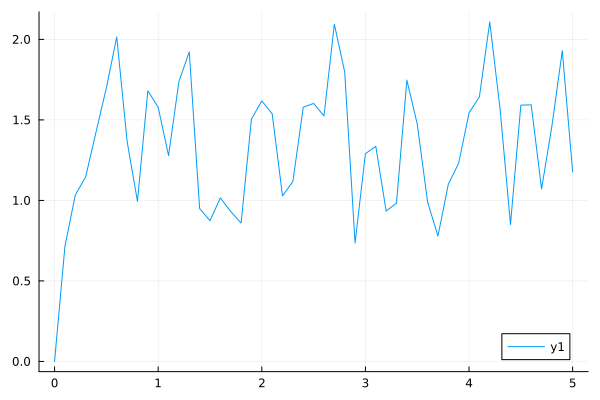

In [17]:
using ITensors, ITensorMPS, Random, HDF5, StatsBase
using Plots

N = 8
sites = siteinds("S=1", N; conserve_qns=true)

os = OpSum()
for j = 1:N ####### change to N-1 if you're doing OBC
  os += 1.0, "S+ * S+", j, "S- * S-", mod(j, N) + 1
  os += 1.0, "S- * S-", j, "S+ * S+", mod(j, N) + 1
  os += 1.0 ,"S+ * S+",mod(j,N)+1,"S- * S-",j   # H.c. terms
  os += 1.0 ,"S- * S-",mod(j,N)+1,"S+ * S+",j
end
H = MPO(os, sites)

# ----- initial product state 
state = [isodd(j) ? "Up" : "Dn" for j in 1:N]       # Néel: isodd(j) ? "Up" : "Dn"
psi = productMPS(sites, state)

#func to compute EE at any site
function entropy_von_neumann(psi, b)
  s = siteinds(psi)
  orthogonalize!(psi, b)
  if b == 1
    U, S, V = svd(psi[b], (siteind(psi, b),))
  else
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
  end
  SvN = 0.0
  for n in 1:dim(S, 1)
    p = S[n, n]^2
    if p > 0
      SvN -= p * log(p)
    end
  end
  return SvN
end

# ----- TDVP evolution + half-chain entropy at every step -----
tstep = 0.1
tend = 5.0
nsw = round(Int, tend / tstep)
tdvp_maxdim = 500

Time = Float64[]
SvN_half = Float64[]

push!(Time, 0.0)
push!(SvN_half, entropy_von_neumann(psi, N ÷ 2))

for n in 1:nsw
  ncenter = 1
  if maxlinkdim(psi) < tdvp_maxdim
    ncenter = 2
  end

  psi = tdvp(H, -im * tstep, psi;
             time_step = -im * tstep,
             reverse_step = true,
             normalize = false,
             cutoff = 1e-10,
             maxdim = tdvp_maxdim,
             nsite = ncenter,
             updater_backend = "exponentiate",
             outputlevel = 1)

  tnow = n * tstep
  push!(Time, tnow)
  push!(SvN_half, entropy_von_neumann(psi, N ÷ 2))

  GC.gc(true)
end

# ----- save results -----
# fname = "SvN_half_vs_time_S1_N$(N)_dt$(tstep)_T$(tend).h5"
# h5write(fname, "time", Time)
# h5write(fname, "SvN_half", SvN_half)
# println("Saved: ", fname)


plot(Time,SvN_half)

In [6]:
include("s3.jl")

neel_spin1 (generic function with 1 method)

In [1]:
using LinearAlgebra

N = 2
function spin1_vector(s)
    s == "Up"  ? [1.0, 0.0, 0.0] :
    s == "Dn"  ? [0.0, 0.0, 1.0] : [0.0, 1.0, 0.0] # "Zero" state
end
neel_state = [isodd(j) ? "Up" : "Dn" for j in 1:N]
psi = spin1_vector(neel_state[1])

for j in 2:N
    psi = kron(psi, spin1_vector(neel_state[j]))
end

In [2]:
psi

9-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [22]:
include("s3.jl")
@time entropy = Entropy_t_z(8, 50.0, 1.0, 1.0, 300)

  8.368313 seconds (35.52 M allocations: 15.520 GiB, 38.11% gc time)


50-element Vector{Float64}:
  6.661338147750935e-16
  0.0
  0.0
  0.0
  2.220446049250312e-16
  2.220446049250312e-16
  0.0
  0.0
  0.0
  0.0
  ⋮
 -4.440892098500629e-16
  0.0
  0.0
 -4.440892098500629e-16
  0.0
  0.0
  0.0
  0.0
  2.220446049250312e-16

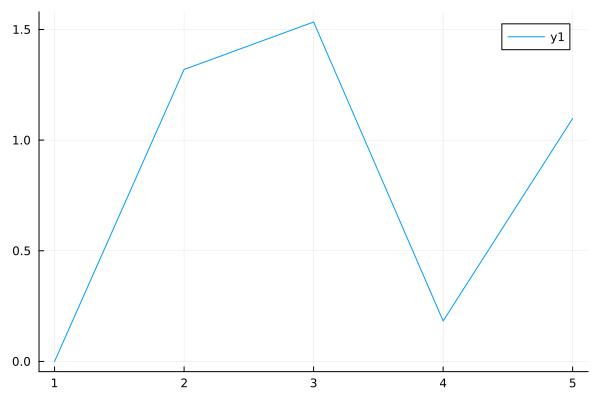

In [18]:
using Plots
plot(entropy)

In [23]:
include("s3.jl")
@time for shot in 1:100
    Entropy_t_z(8, 50.0, 1.0, 1.0, shot)
end

627.302886 seconds (2.43 G allocations: 1.284 TiB, 36.48% gc time)
